In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
digits = load_digits()
X = digits.images[:, np.newaxis, :, :] / 16.0  # shape: (N, 1, 8, 8)
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)     # -> (16, 8, 8)
        self.pool = nn.MaxPool2d(2, 2)                  # -> (16, 4, 4)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)    # -> (32, 4, 4)
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))            # -> (16, 4, 4)
        x = self.pool(F.relu(self.conv2(x)))            # -> (32, 2, 2)
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
writer = SummaryWriter("runs/digits_cnn")


In [6]:
sample_input = torch.randn(1, 1, 8, 8)
writer.add_graph(model, sample_input)

In [7]:
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", accuracy, epoch)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/20, Loss: 2.2306, Accuracy: 0.3034
Epoch 2/20, Loss: 1.6901, Accuracy: 0.5727
Epoch 3/20, Loss: 0.8709, Accuracy: 0.7606
Epoch 4/20, Loss: 0.5113, Accuracy: 0.8615
Epoch 5/20, Loss: 0.3796, Accuracy: 0.8887
Epoch 6/20, Loss: 0.2880, Accuracy: 0.9172
Epoch 7/20, Loss: 0.2253, Accuracy: 0.9381
Epoch 8/20, Loss: 0.1827, Accuracy: 0.9520
Epoch 9/20, Loss: 0.1597, Accuracy: 0.9541
Epoch 10/20, Loss: 0.1414, Accuracy: 0.9603
Epoch 11/20, Loss: 0.1157, Accuracy: 0.9715
Epoch 12/20, Loss: 0.1001, Accuracy: 0.9743
Epoch 13/20, Loss: 0.0885, Accuracy: 0.9791
Epoch 14/20, Loss: 0.0829, Accuracy: 0.9812
Epoch 15/20, Loss: 0.0693, Accuracy: 0.9840
Epoch 16/20, Loss: 0.0604, Accuracy: 0.9875
Epoch 17/20, Loss: 0.0569, Accuracy: 0.9889
Epoch 18/20, Loss: 0.0469, Accuracy: 0.9903
Epoch 19/20, Loss: 0.0488, Accuracy: 0.9896
Epoch 20/20, Loss: 0.0405, Accuracy: 0.9896


In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for Xb, yb in test_loader:
        outputs = model(Xb)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

Text(0.5, 1.0, 'Confusion Matrix')

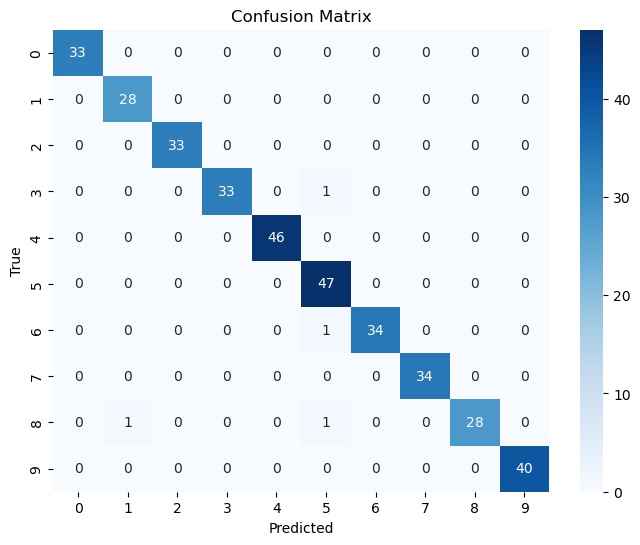

In [9]:
conf_mat = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [10]:
os.makedirs("figs", exist_ok=True)
fig_path = "figs/confusion_matrix.png"
plt.savefig(fig_path)
img_tensor = torch.tensor(plt.imread(fig_path)).permute(2, 0, 1)
writer.add_image("Confusion Matrix", img_tensor, dataformats='CHW')


<Figure size 640x480 with 0 Axes>

In [11]:
images = X_test[:10]
labels = y_test[:10]
with torch.no_grad():
    preds = model(images)
    pred_labels = preds.argmax(1)

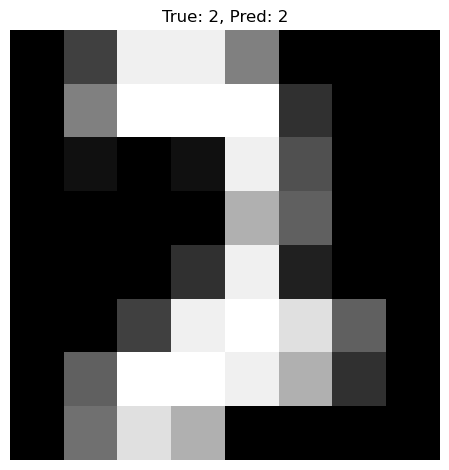

In [12]:
for i in range(10):
    img = images[i][0].numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {labels[i].item()}, Pred: {pred_labels[i].item()}")
    plt.axis("off")
    plt.tight_layout()
    path = f"figs/sample_{i}.png"
    plt.savefig(path)
    img_tensor = torch.tensor(plt.imread(path)).permute(2, 0, 1)
    writer.add_image(f"Prediction/{i}", img_tensor, dataformats="CHW")


In [13]:
writer.close()
